In [1]:
%matplotlib inline
import numpy as np
import scipy
import scipy.io
import scipy.sparse as sp
import matplotlib.pyplot as plt
from src.helpers import *
from src.plots import *
from src.mf_gd import *
from src.baseline_predictions import *
%load_ext autoreload
%autoreload 2

# 1) Load data

number of items: 10000, number of users: 1000


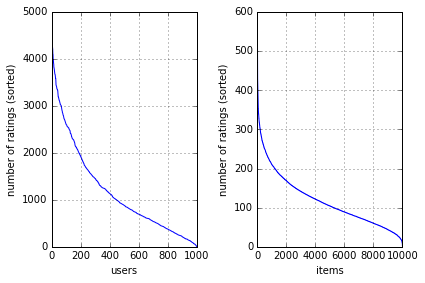

In [2]:
path_dataset = "../data/data_train.csv"
ratings = load_data(path_dataset)

num_items_per_user, num_users_per_item = plot_raw_data(ratings)

# 2) Find the best values of the hyper-parameters

## Find the number of iterations until convergence: 20 seems enough

In [ ]:
_,train_for_epochs,test_for_epochs = split_data(ratings, num_items_per_user, num_users_per_item, min_num_ratings=0, p_test=0.1)

In [ ]:
gamma = 0.01
num_features=20
lambda_user = 0
lambda_item = 0
num_epochs = 35

rmse_train, rmse_test = mf_gd_regularized(train_for_epochs, test_for_epochs, num_epochs, gamma, num_features, lambda_user, lambda_item)

In [ ]:
filename = "mf_cv_num_epoch.png"

# Visualization of the evolution of the RMSE versus the epochs
visualization_num_epochs(rmse_train, rmse_test, num_epochs, filename)

## Find  "number of features"

In [ ]:
lambda_item = 0
lambda_user = 0

num_features = np.arange(10,280,30)

k_fold = 4
num_epochs = 20
gamma = 0.01

# Run cross-validation to find the best value of lambda item. The output is a plot of RMSE vs lambda
rmse_tr, rmse_te = run_mf_cv_num_features(ratings, k_fold, num_epochs, num_features, lambda_user, lambda_item)

Learn the matrix factorization using SGD...


In [ ]:
filename = "mf_sgd_cv_num_features.png"
visualization_num_features(rmse_tr, rmse_te, num_features, filename)

## Find lambda user

In [ ]:
lambdas_user = np.array([0.0000001, 0.000001, 0.00001, 0.0001, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 3])[:,np.newaxis]
lambda_item = 0

num_features = 20

k_fold = 4
num_epochs = 20
gamma = 0.01

# Run cross-validation to find the best value of lambda user. The output is a plot of RMSE vs lambda
rmse_tr, rmse_te = run_mf_cv_lambda_user(ratings, k_fold, num_epochs, num_features, lambdas_user, lambda_item)

In [ ]:
filename = "mf_sgd_reg_cv_lambda_user.png"
visualization_lambda_user(rmse_tr, rmse_te, lambdas_user, filename)

## Find lambda item

In [ ]:
lambdas_item = np.array([0.0000001, 0.000001, 0.00001, 0.0001, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 3])[:,np.newaxis]
lambda_user = 0

num_features = 20

k_fold = 4
num_epochs = 20
gamma = 0.01

# Run cross-validation to find the best value of lambda item. The output is a plot of RMSE vs lambda
rmse_tr, rmse_te = run_mf_cv_lambda_item(ratings, k_fold, num_epochs, num_features, lambda_user, lambdas_item)

In [ ]:
filename = "mf_sgd_reg_cv_lambda_item.png"
visualization_lambda_item(rmse_tr, rmse_te, lambdas_item, filename)

## (Find lambdas user and item) - useful ?

In [ ]:
num_epochs = 10 
gamma = 0.01

lambdas = np.array([0.0001, 0.01, 0.05, 0.1, 0.5])[:,np.newaxis]

lambdas_user = np.repeat(lambdas, len(lambdas))[:,np.newaxis]
lambdas_item = np.kron(np.ones((len(lambdas),1)), lambdas)

num_experiments = len(lambdas_user)
rmse_train = np.zeros((num_experiments, 1))
rmse_test = np.zeros((num_experiments, 1))

num_features = 30

for i in range(0, len(lambdas_user)):
    print('MF SGD started for lambdas(user,item) = (%s,%s)' % (str(lambdas_user[i]),str(lambdas_item[i])))
    rmse_train[i], rmse_test[i] = mf_gd(train, test, num_epochs, gamma, num_features, lambdas_user[i], lambdas_item[i])


In [ ]:
visualization_rmse_vs_lambdas(lambdas_user, lambdas_item, rmse_train, rmse_test, "rmse_vs_lambdas.png")


# Comparison of different models

In [ ]:
def print_results(rmse_tr, rmse_te):
    mean_tr = np.mean(rmse_tr, axis=0)
    std_tr = np.std(rmse_tr, axis=0)

    mean_te = np.mean(rmse_te, axis=0)
    std_te = np.std(rmse_te, axis=0)

    print("RMSE train, mean: %f, std: %f" % (mean_tr, std_tr))
    print("RMSE test, mean: %f, std: %f" % (mean_te, std_te))

In [ ]:
# Common parameters
k_fold = 4
num_epochs = 30
num_features = 20

# Different baselines

## Global mean baseline

In [ ]:
rmse_tr, rmse_te = run_cross_validation_global_baseline(ratings, k_fold)

print_results(rmse_tr, rmse_te)

## User mean baseline

In [ ]:
rmse_tr, rmse_te = run_cross_validation_user_baseline(ratings, k_fold)

print_results(rmse_tr, rmse_te)

## Item mean baseline

In [ ]:
rmse_tr, rmse_te = run_cross_validation_item_baseline(ratings, k_fold)

print_results(rmse_tr, rmse_te)

## MF without regularizer

In [ ]:
rmse_tr, rmse_te = run_mf_cv(ratings, k_fold, num_epochs, num_features)

print_results(rmse_tr, rmse_te)

## MF with regularizer

In [ ]:
lambda_user = 0.001
lambdas_item = 0.1
rmse_tr, rmse_te = run_mf_reg_cv(ratings, k_fold, num_epochs, num_features, lambda_user, lambdas_item)

print_results(rmse_tr, rmse_te)

# 3) Compute best predictions using the best values of the hyper-parameters

In [21]:
"""matrix factorization by GD."""

# Use all ratings
data = ratings

# Parameters
gamma = 0.01
num_features = 40
lambda_user = 0.001
lambda_item = 0.1
num_epochs = 30

X_hat, rmse = mf_gd_compute_predictions(data, num_epochs, gamma, num_features, lambda_user, lambda_item)

learn the matrix factorization using SGD...
Starting epoch number 0
Starting epoch number 5
Starting epoch number 10
Starting epoch number 15
Starting epoch number 20
Starting epoch number 25


(30,)


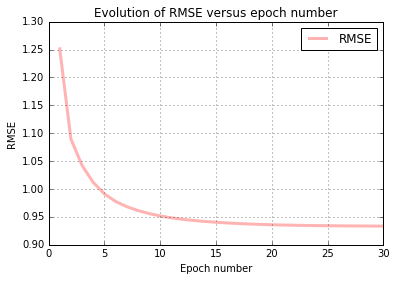

In [22]:
filename = "rmse_vs_num_epochs_best_predictions.png"
visualization_num_epochs_best_predictions(rmse, num_epochs, filename)

# 4) Create submission from the best predictions 
Note: Run steps 1 and 3 before 4

In [23]:
from collections import deque
import datetime
from helpers import *
now = datetime.datetime.now()
now_str = now.strftime("%d-%m-%Y_%Hh%M_%S")
output_path = '../data/predictions-%s-group-clm_.csv' % now_str

indices = extract_indices('../data/sampleSubmission.csv')

ratings_to_write = deque()
for row, col in indices:
    ratings_to_write.append((row, col, X_hat[row,col]))
    
create_csv_submission(ratings_to_write, output_path)


999   0
